In [1]:
# Importing libraries
import numpy as np 
import pandas as pd 
import os
import numpy as np
import pandas as pd
import scipy.io
from skimage.transform import resize
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import keras
import os



import csv,sys
from collections import namedtuple
from PIL import Image
from sklearn.feature_extraction import image
from sklearn.feature_extraction.image import extract_patches
from skimage.util.shape import view_as_windows
import csv
from collections import namedtuple
import random

import segmentation_models as sm
from segmentation_models.utils import set_trainable

import gc
gc.collect()

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


27

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# Columbia Dataset #

## Preparing Train-Validation-Test Dataset##

In [3]:
# Columbia dataset: http://www.ee.columbia.edu/ln/dvmm/downloads/authsplcuncmp/

base_folder='D:/APPLIEDAI/souravD/image-splicing-localization-master/data'
#base_folder='G:/sourav/prog/notebook/Image_manipulation_detection-master/image-splicing-localization-master/data/'
data = 'columbia_img'

original_images = [os.path.join(base_folder, '4cam_splc')+'/'+x for x in os.listdir(
    os.path.join(base_folder, '4cam_splc')) if x.endswith(".tif")]
print(len(original_images))

180


In [4]:
train_rows = []
val_rows = []
test_rows = []

for v in original_images:
    rr = random.random()
    if rr<= 0.65:
        train_rows.append(v)
    elif rr <=0.75:
        val_rows.append(v)
    else:
        test_rows.append(v)
        
print(len(train_rows))
print(len(val_rows))
print(len(test_rows))

123
13
44


In [5]:
dic = {
    'train':train_rows,
    'val':val_rows,
    'test':test_rows
}

In [6]:
for str_type in ['train','val','test']:

    count = 0
    lst = []
    
    # mkdirs
    os.makedirs(os.path.join(base_folder,data,'images',str_type))
    os.makedirs(os.path.join(base_folder,data,'masks',str_type))
    
    print("str_type ",str_type)
    
    for img_path in dic[str_type]: # each image in dic

        IMG_PATH = img_path
        MASK_PATH = img_path.replace('4cam_splc', 'edgemask').replace('.tif', '_edgemask.jpg')
        
        print("IMG_PATH: ",IMG_PATH)
        print("MASK_PATH: ",MASK_PATH)

        prob = Image.open(IMG_PATH)
        rgbmask = Image.open(MASK_PATH) # here the mask is in rgb form, we need to change to 255
        
        assert prob.size == rgbmask.size
        width,height = prob.size

        rgbmask = np.array(rgbmask)
        prob = np.array(prob)
        
        idx = np.argmax(rgbmask,2)

        mask = np.zeros([rgbmask.shape[0],rgbmask.shape[1]])
        mask[idx == 0] = 255 # rgb
        
        im = Image.fromarray(prob)
        mk = Image.fromarray(mask).convert('RGB')
        
        PROCESSED_IMG_PATH = os.path.join(data, 'images', str_type, str(count)+'.png')
        PROCESSED_MASK_PATH = os.path.join(data, 'masks', str_type, str(count)+'.png')
        
        im.save(base_folder+'/'+PROCESSED_IMG_PATH)
        mk.save(base_folder+'/'+PROCESSED_MASK_PATH)
        
        lst.append(",".join([PROCESSED_IMG_PATH, PROCESSED_MASK_PATH, MASK_PATH.replace(
                    base_folder, ''), IMG_PATH.replace(base_folder, '')]))
        
        count = count + 1
        print('['+str(count)+']') 
        
    with open(os.path.join(base_folder,data,str_type+'.txt'),'w') as f:
        f.write("\n".join(lst)) 


str_type  train
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data\4cam_splc/canong3_canonxt_sub_01.tif
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data\edgemask/canong3_canonxt_sub_01_edgemask.jpg
[1]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data\4cam_splc/canong3_canonxt_sub_02.tif
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data\edgemask/canong3_canonxt_sub_02_edgemask.jpg
[2]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data\4cam_splc/canong3_canonxt_sub_03.tif
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data\edgemask/canong3_canonxt_sub_03_edgemask.jpg
[3]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data\4cam_splc/canong3_canonxt_sub_04.tif
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data\edgemask/canong3_canonxt_sub_04_edgemask.jpg
[4]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-

[35]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data\4cam_splc/canong3_kodakdcs330_sub_21.tif
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data\edgemask/canong3_kodakdcs330_sub_21_edgemask.jpg
[36]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data\4cam_splc/canong3_kodakdcs330_sub_23.tif
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data\edgemask/canong3_kodakdcs330_sub_23_edgemask.jpg
[37]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data\4cam_splc/canong3_kodakdcs330_sub_25.tif
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data\edgemask/canong3_kodakdcs330_sub_25_edgemask.jpg
[38]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data\4cam_splc/canong3_kodakdcs330_sub_27.tif
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data\edgemask/canong3_kodakdcs330_sub_27_edgemask.jpg
[39]
IMG_PATH:  D:/APPLIEDAI/souravD/ima

[70]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data\4cam_splc/canonxt_kodakdcs330_sub_15.tif
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data\edgemask/canonxt_kodakdcs330_sub_15_edgemask.jpg
[71]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data\4cam_splc/canonxt_kodakdcs330_sub_16.tif
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data\edgemask/canonxt_kodakdcs330_sub_16_edgemask.jpg
[72]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data\4cam_splc/canonxt_kodakdcs330_sub_19.tif
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data\edgemask/canonxt_kodakdcs330_sub_19_edgemask.jpg
[73]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data\4cam_splc/canonxt_kodakdcs330_sub_20.tif
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data\edgemask/canonxt_kodakdcs330_sub_20_edgemask.jpg
[74]
IMG_PATH:  D:/APPLIEDAI/souravD/ima

[105]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data\4cam_splc/nikond70_kodakdcs330_sub_01.tif
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data\edgemask/nikond70_kodakdcs330_sub_01_edgemask.jpg
[106]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data\4cam_splc/nikond70_kodakdcs330_sub_02.tif
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data\edgemask/nikond70_kodakdcs330_sub_02_edgemask.jpg
[107]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data\4cam_splc/nikond70_kodakdcs330_sub_03.tif
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data\edgemask/nikond70_kodakdcs330_sub_03_edgemask.jpg
[108]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data\4cam_splc/nikond70_kodakdcs330_sub_05.tif
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data\edgemask/nikond70_kodakdcs330_sub_05_edgemask.jpg
[109]
IMG_PATH:  D:/APPLIEDA

[3]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data\4cam_splc/canong3_canonxt_sub_19.tif
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data\edgemask/canong3_canonxt_sub_19_edgemask.jpg
[4]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data\4cam_splc/canong3_canonxt_sub_21.tif
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data\edgemask/canong3_canonxt_sub_21_edgemask.jpg
[5]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data\4cam_splc/canong3_canonxt_sub_30.tif
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data\edgemask/canong3_canonxt_sub_30_edgemask.jpg
[6]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data\4cam_splc/canong3_kodakdcs330_sub_02.tif
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data\edgemask/canong3_kodakdcs330_sub_02_edgemask.jpg
[7]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-mast

[38]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data\4cam_splc/nikond70_kodakdcs330_sub_15.tif
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data\edgemask/nikond70_kodakdcs330_sub_15_edgemask.jpg
[39]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data\4cam_splc/nikond70_kodakdcs330_sub_17.tif
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data\edgemask/nikond70_kodakdcs330_sub_17_edgemask.jpg
[40]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data\4cam_splc/nikond70_kodakdcs330_sub_20.tif
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data\edgemask/nikond70_kodakdcs330_sub_20_edgemask.jpg
[41]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data\4cam_splc/nikond70_kodakdcs330_sub_22.tif
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data\edgemask/nikond70_kodakdcs330_sub_22_edgemask.jpg
[42]
IMG_PATH:  D:/APPLIEDAI/sou

## Dataloader and utility functions ##

In [4]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = {'manipulated': 0, 'non_manipulated': 255}
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES[cls] for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        dim= (512,512)
        
        img = cv2.imread(self.images_fps[i], cv2.COLOR_BGR2RGB)
        image = cv2.resize(img, dim, interpolation = cv2.INTER_AREA) # Downscale without Preserving Aspect Ratio
        
        msk = cv2.imread(self.masks_fps[i], 0)
        mask = cv2.resize(msk, dim, interpolation = cv2.INTER_AREA) # Downscale without Preserving Aspect Ratio
        masks = [(mask == self.class_values) ]
        mask = np.stack(masks, axis=-1).astype('float')

        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        image = np.array(image).astype(np.float32) / 255
                   
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))
        self.on_epoch_end()
        
        

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

## Augmentations ##

In [5]:
import albumentations as A

In [6]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation(WIDTH=64, HEIGHT=64):
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=HEIGHT, min_width=WIDTH, always_apply=True, border_mode=0),
        A.RandomCrop(height=HEIGHT, width=WIDTH, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation(WIDTH=64, HEIGHT=64):
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(min_height=HEIGHT, min_width=WIDTH)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

## Segmentation model training ##

In [7]:
x_train_dir=base_folder+'/columbia_img/images/train'
y_train_dir=base_folder+'/columbia_img/masks/train'

x_valid_dir=base_folder+'/columbia_img/images/val'
y_valid_dir=base_folder+'/columbia_img/masks/val'

x_test_dir=base_folder+'/columbia_img/images/test'
y_test_dir=base_folder+'/columbia_img/masks/test'

In [8]:
BACKBONE = 'efficientnetb3'
BATCH_SIZE = 2
CLASSES = ['manipulated']
LR = 0.0001
EPOCHS = 50
n_classes = 1
activation = 'sigmoid'

preprocess_input = sm.get_preprocessing(BACKBONE)

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [9]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss()
total_loss = dice_loss + (1 * focal_loss) #+ sm.losses.BinaryCELoss()


metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)



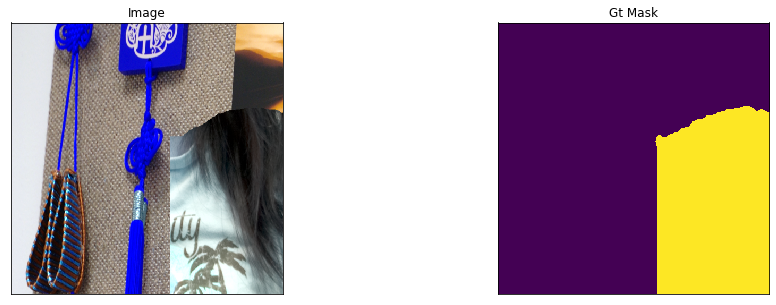

In [10]:
# Showing samp;e data
sample_dataset = Dataset(x_train_dir, y_train_dir, classes=CLASSES,)

sample_image, sample_mask = sample_dataset[5] # get some sample
visualize(
        image=denormalize(sample_image.squeeze()),
        gt_mask=sample_mask[..., 0].squeeze(),
    )

In [11]:
# Initializing Train dataset without augmentation

train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    #augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

D:\Installed\Anaconda3\lib\site-packages\albumentations\augmentations\transforms.py:2908: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  "Using lambda is incompatible with multiprocessing. "


In [12]:
# Initializing Validation dataset

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    #augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

In [13]:
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model_columbia.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

In [15]:
# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 512, 512, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 512, 512, n_classes)

# Trains the model on data generated batch-by-batch
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/50
61/61 [==============================] - 40s 662ms/step - loss: 0.7113 - iou_score: 0.2438 - f1-score: 0.3565 - val_loss: 0.8857 - val_iou_score: 0.0273 - val_f1-score: 0.0501
Epoch 2/50
61/61 [==============================] - 17s 287ms/step - loss: 0.4068 - iou_score: 0.7343 - f1-score: 0.8398 - val_loss: 0.8701 - val_iou_score: 0.0420 - val_f1-score: 0.0732
Epoch 3/50
61/61 [==============================] - 18s 290ms/step - loss: 0.2498 - iou_score: 0.8790 - f1-score: 0.9336 - val_loss: 0.9345 - val_iou_score: 0.0662 - val_f1-score: 0.1119
Epoch 4/50
61/61 [==============================] - 18s 296ms/step - loss: 0.1767 - iou_score: 0.9198 - f1-score: 0.9572 - val_loss: 0.9984 - val_iou_score: 0.0683 - val_f1-score: 0.1197
Epoch 5/50
61/61 [==============================] - 18s 301ms/step - loss: 0.1376 - iou_score: 0.9353 - f1-score: 0.9655 - val_loss: 1.0385 - val_iou_score: 

Epoch 42/50
61/61 [==============================] - 19s 304ms/step - loss: 0.0109 - iou_score: 0.9906 - f1-score: 0.9953 - val_loss: 0.0743 - val_iou_score: 0.9052 - val_f1-score: 0.9329
Epoch 43/50
61/61 [==============================] - 19s 305ms/step - loss: 0.0107 - iou_score: 0.9908 - f1-score: 0.9954 - val_loss: 0.0750 - val_iou_score: 0.9058 - val_f1-score: 0.9335
Epoch 44/50
61/61 [==============================] - 19s 305ms/step - loss: 0.0106 - iou_score: 0.9910 - f1-score: 0.9955 - val_loss: 0.0764 - val_iou_score: 0.9054 - val_f1-score: 0.9330
Epoch 45/50
61/61 [==============================] - 19s 305ms/step - loss: 0.0109 - iou_score: 0.9906 - f1-score: 0.9953 - val_loss: 0.0758 - val_iou_score: 0.9054 - val_f1-score: 0.9330
Epoch 46/50
61/61 [==============================] - 19s 305ms/step - loss: 0.0106 - iou_score: 0.9909 - f1-score: 0.9954 - val_loss: 0.0758 - val_iou_score: 0.9057 - val_f1-score: 0.9334
Epoch 47/50
61/61 [==============================] - 19s 306

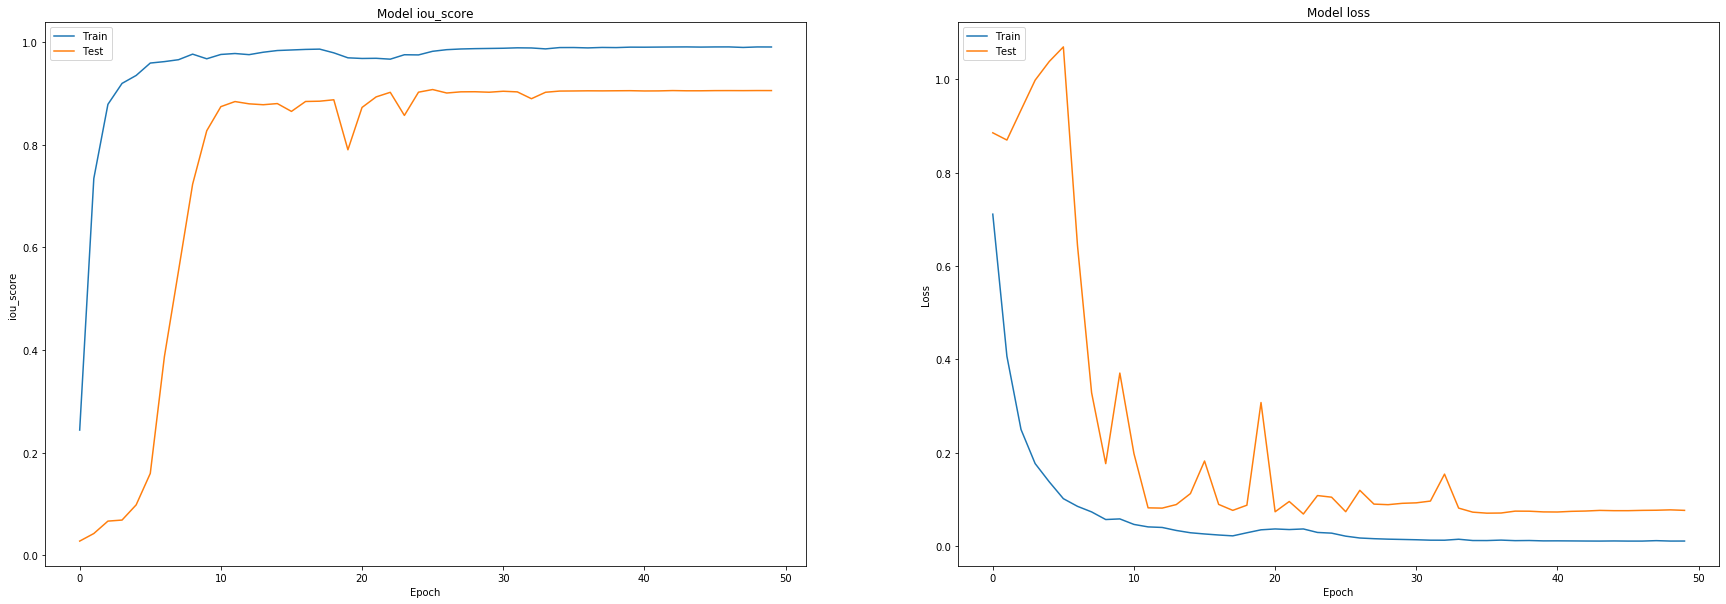

In [16]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 10))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Model Evaluation ##

In [17]:
# Initializing Test dataset

test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

D:\Installed\Anaconda3\lib\site-packages\albumentations\augmentations\transforms.py:2908: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  "Using lambda is incompatible with multiprocessing. "


In [18]:
model.load_weights('./best_model_columbia.h5')

In [19]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.021272
mean iou_score: 0.87692
mean f1-score: 0.91978


## Visualization of results on test dataset ##

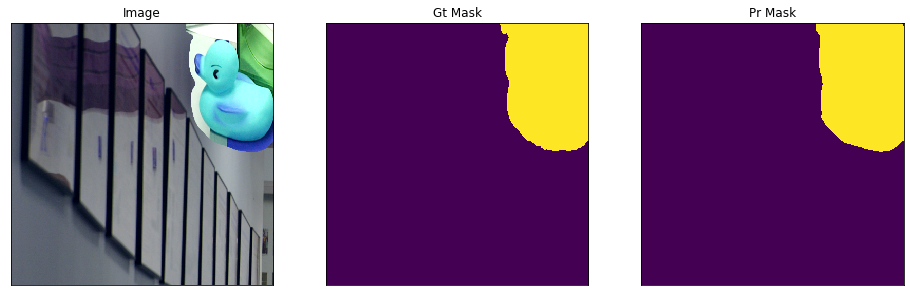

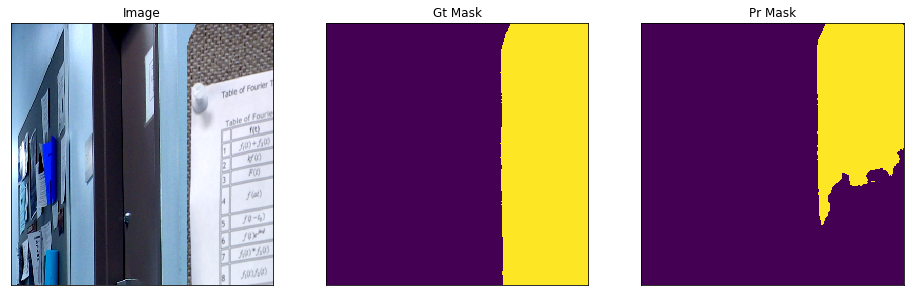

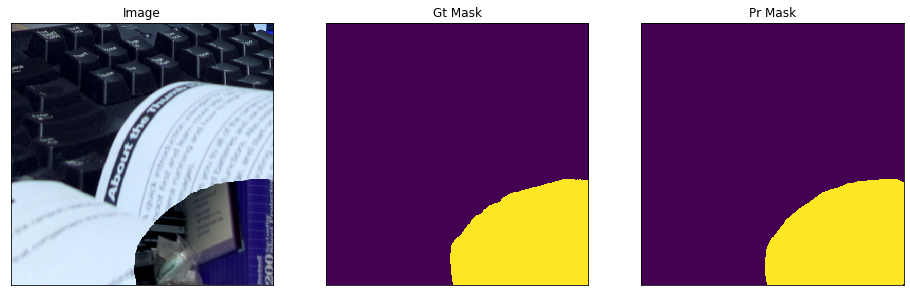

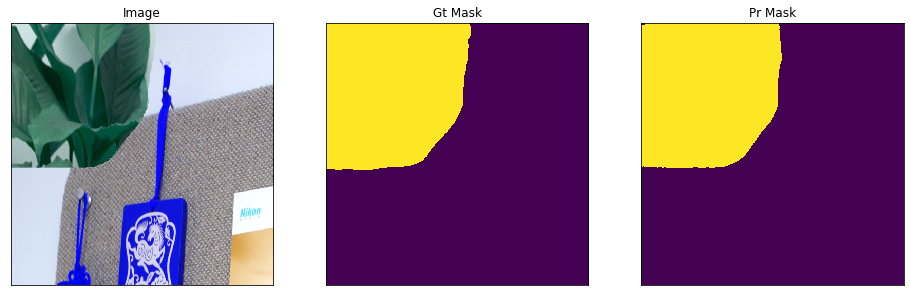

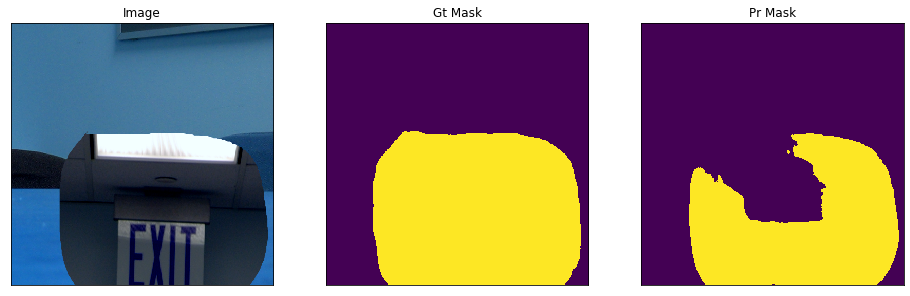

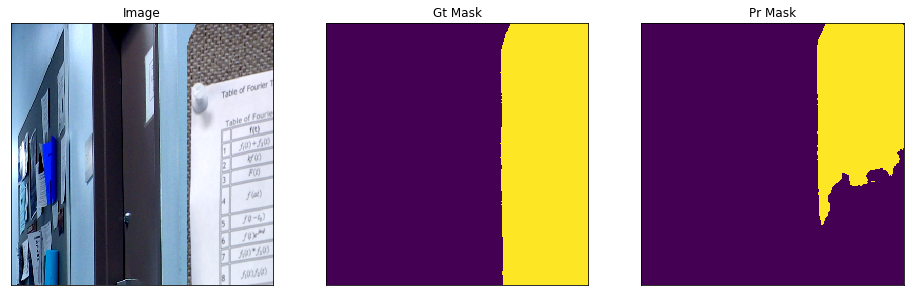

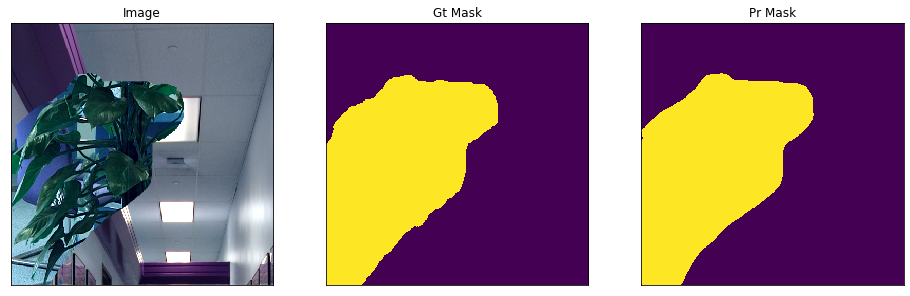

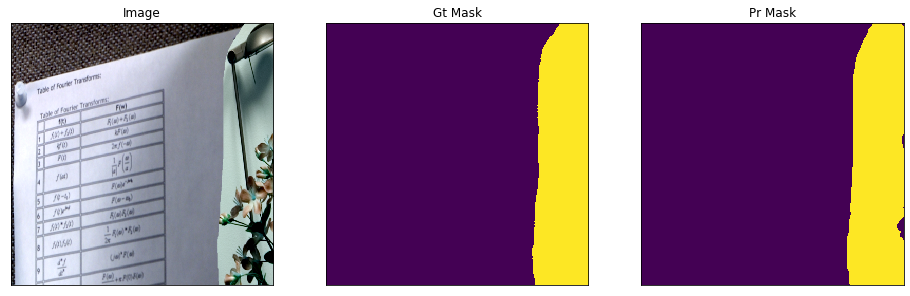

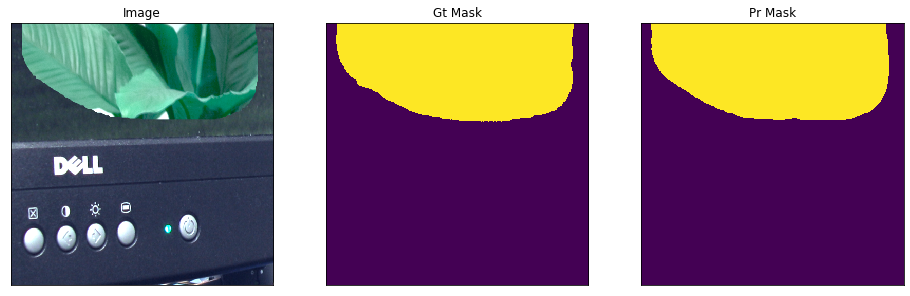

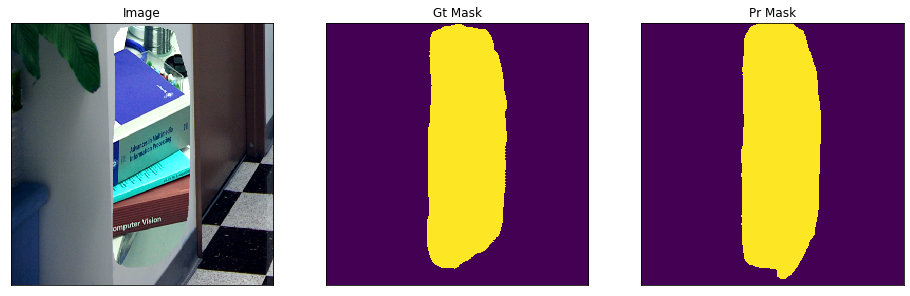

In [20]:
n = 10
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask[..., 0].squeeze(),
        pr_mask=pr_mask[..., 0].squeeze(),
    )